# Supplemental Capstone Report: Temporal Dynamics of Business Density: A Time-Series Analysis of ZIP Code and Sector Effects


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Updated imports for Machine Learning models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf


### Load data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Final_lightRail_dataset.csv to Final_lightRail_dataset.csv


In [ ]:
data = pd.read_csv('Final_lightRail_dataset.csv')
df = pd.DataFrame(data)

In [ ]:
df.dropna(inplace=True)

In [ ]:
bds = df[['ZIP','Year','EstablishmentCount','Establishment_Sector','Business_Density','Log_Business_Density']]

In [ ]:
bds.describe()

,ZIP,Year,EstablishmentCount,Business_Density,Log_Business_Density
count,45196.000000,45196.000000,45196.000000,45196.000000,45196.000000
mean,85195.551686,2011.356447,42.598571,4.760383,1.204651
std,134.089348,6.771771,56.498780,9.261266,0.965957
min,85003.000000,2000.000000,1.000000,0.000490,0.000490
25%,85040.000000,2006.000000,7.000000,0.432475,0.359404
50%,85226.000000,2011.000000,21.000000,1.711712,0.997580
75%,85305.000000,2017.000000,59.000000,6.087564,1.958342
max,85396.000000,2023.000000,607.000000,205.500000,5.330300


In [ ]:
output_path = "Business_Sector.csv"
bds.to_csv(output_path, index=False)

In [ ]:
FILE_PATH = 'Business_Sector.csv'

try:
    # Load the data
    df = pd.read_csv(FILE_PATH)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{FILE_PATH}' was not found. Please upload it to your Colab environment.")
    df = None
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    df = None

if df is not None:
    # Data Cleaning and Preparation
    df.columns = df.columns.str.replace(' ', '_').str.strip()
    df['Year'] = df['Year'].astype(int)
    # Convert ZIP to string for fixed effects in modeling
    df['ZIP'] = df['ZIP'].astype(str)

    print("\nInitial Data Head:")
    print(df.head())
    print("\nData Info:")
    df.info()

Data loaded successfully.

Initial Data Head:
     ZIP  Year  EstablishmentCount   Establishment_Sector  Business_Density  \
0  85003  2000                  17           Construction          8.095238   
1  85003  2000                  13          Manufacturing          6.190476   
2  85003  2000                  16        Wholesale_Trade          7.619048   
3  85003  2000                  24           Retail_Trade         11.428571   
4  85003  2000                   8  Transport_Warehousing          3.809524   

   Log_Business_Density  
0              2.207751  
1              1.972757  
2              2.153975  
3              2.519998  
4              1.570598  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45196 entries, 0 to 45195
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ZIP                   45196 non-null  object 
 1   Year                  45196 non-null  int64  

## Exploratory Data Analysis (EDA) & Data Preparation

### How business density changes over time (ZIP Level)

In [ ]:
min_year = df['Year'].min()
max_year = df['Year'].max()


# Aggregate average Log_Business_Density per ZIP per Year
zip_density_yearly = df.groupby(['Year', 'ZIP'])['Log_Business_Density'].mean().reset_index(name='Avg_Log_Density')

# Create the Lagged Variable for Modeling (AR term)
# Sort data by ZIP and Establishment_Sector and Year for correct lagging
df_sorted = df.sort_values(by=['ZIP', 'Establishment_Sector', 'Year'])
df_sorted['Lagged_Log_Density'] = df_sorted.groupby(['ZIP', 'Establishment_Sector'])['Log_Business_Density'].shift(1)

# Drop rows where lagged density is NaN
df_model = df_sorted.dropna(subset=['Lagged_Log_Density']).copy()

# Calculate ZIP change
df_zip_start = zip_density_yearly[zip_density_yearly['Year'] == min_year].rename(
  columns={'Avg_Log_Density': f'LogDensity_{min_year}'}
  ).drop(columns=['Year'])

df_zip_end = zip_density_yearly[zip_density_yearly['Year'] == max_year].rename(
  columns={'Avg_Log_Density': f'LogDensity_{max_year}'}
  ).drop(columns=['Year'])

zip_change_analysis = pd.merge(df_zip_start, df_zip_end, on='ZIP', how='inner')

zip_change_analysis['Log_Density_Increase'] = (
zip_change_analysis[f'LogDensity_{max_year}'] - zip_change_analysis[f'LogDensity_{min_year}'])


In [ ]:
output_path = "zip_change_analysis.csv"
zip_change_analysis.to_csv(output_path, index=False)

In [ ]:
# Top/Bottom 5 by absolute change in log density
top_growth_zips = zip_change_analysis.nlargest(5, 'Log_Density_Increase').round(3)
top_decline_zips = zip_change_analysis.nsmallest(5, 'Log_Density_Increase').round(3)

print("\nTop 5 ZIP Codes by Absolute Log Density Increase:")
print(top_growth_zips.to_markdown(index=False))
print("\nTop 5 ZIP Codes by Absolute Log Density Decline:")
print(top_decline_zips.to_markdown(index=False))


Top 5 ZIP Codes by Absolute Log Density Increase:
|   ZIP |   LogDensity_2000 |   LogDensity_2023 |   Log_Density_Increase |
|------:|------------------:|------------------:|-----------------------:|
| 85305 |             0.411 |             1.688 |                  1.277 |
| 85378 |             0.318 |             1.302 |                  0.985 |
| 85296 |             0.778 |             1.759 |                  0.981 |
| 85050 |             0.416 |             1.382 |                  0.966 |
| 85042 |             0.407 |             1.322 |                  0.916 |

Top 5 ZIP Codes by Absolute Log Density Decline:
|   ZIP |   LogDensity_2000 |   LogDensity_2023 |   Log_Density_Increase |
|------:|------------------:|------------------:|-----------------------:|
| 85023 |             1.539 |             1.52  |                 -0.019 |
| 85390 |             0.013 |             0.021 |                  0.008 |
| 85326 |             0.005 |             0.018 |                  0.013 |

### Sector Composition and Change (Sector Level)

In [ ]:
#Aggregate Establishment Count and Density by Sector and Year
sector_yearly = df.groupby(['Year', 'Establishment_Sector']).agg(
    Total_EstablishmentCount=('EstablishmentCount', 'sum'),
    Avg_Log_Density=('Log_Business_Density', 'mean')
    ).reset_index()

#Calculate multi-year % change in Establishment Count
df_sector_start = sector_yearly[sector_yearly['Year'] == min_year].rename(
    columns={'Total_EstablishmentCount': f'Count_{min_year}'}
    ).drop(columns=['Year'])

df_sector_end = sector_yearly[sector_yearly['Year'] == max_year].rename(
    columns={'Total_EstablishmentCount': f'Count_{max_year}'}
    ).drop(columns=['Year'])

sector_change_analysis = pd.merge(df_sector_start, df_sector_end, on='Establishment_Sector', how='inner')

sector_change_analysis['Count_Change_%'] = (
    (sector_change_analysis[f'Count_{max_year}'] - sector_change_analysis[f'Count_{min_year}']) /
    sector_change_analysis[f'Count_{min_year}']
    ) * 100

In [ ]:
output_path = "sector_change_analysis.csv"
sector_change_analysis.to_csv(output_path, index=False)

In [ ]:
# Top/Bottom 5 sectors by percentage change
top_growth_sectors = sector_change_analysis.nlargest(5, 'Count_Change_%').round(2)
top_decline_sectors = sector_change_analysis.nsmallest(5, 'Count_Change_%').round(2)

print("\nTop 5 Sectors by Establishment Count Percentage Growth (Overall):")
print(top_growth_sectors[['Establishment_Sector', 'Count_Change_%']].to_markdown(index=False))
print("\nTop 5 Sectors by Establishment Count Percentage Decline (Overall):")
print(top_decline_sectors[['Establishment_Sector', 'Count_Change_%']].to_markdown(index=False))


Top 5 Sectors by Establishment Count Percentage Growth (Overall):
| Establishment_Sector     |   Count_Change_% |
|:-------------------------|-----------------:|
| Educational_Services     |           128.68 |
| Health_Social_Assistance |           114.19 |
| Real_Estate_Leasing      |           112.26 |
| Transport_Warehousing    |            99    |
| Arts_Entertainment_Rec   |            95.15 |

Top 5 Sectors by Establishment Count Percentage Decline (Overall):
| Establishment_Sector   |   Count_Change_% |
|:-----------------------|-----------------:|
| 99_Other_99            |           -96.15 |
| Mining                 |           -47.06 |
| Ag_Forestry_Fishing    |           -43.66 |
| Utilities              |           -38.89 |
| Manufacturing          |            -9.03 |


## Visualizations

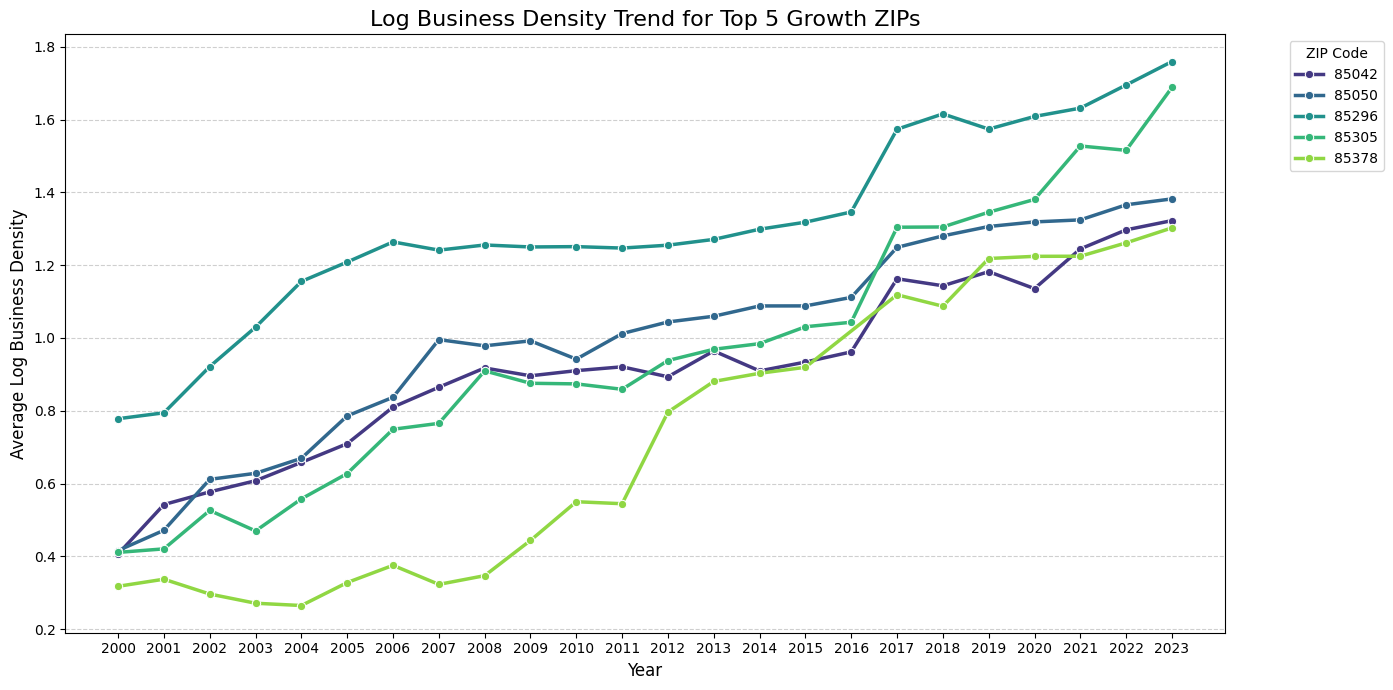

In [ ]:
# Line chart of Log Density over time for the top 5 growing ZIPs
top_zips_list = top_growth_zips['ZIP'].tolist()
df_plot_zips = zip_density_yearly[zip_density_yearly['ZIP'].isin(top_zips_list)]

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_plot_zips,
    x='Year',
    y='Avg_Log_Density',
    hue='ZIP',
    marker='o',
    palette='viridis',
    linewidth=2.5
)
plt.title(f'Log Business Density Trend for Top {len(top_zips_list)} Growth ZIPs', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Log Business Density', fontsize=12)
plt.xticks(zip_density_yearly['Year'].unique())
plt.legend(title='ZIP Code', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

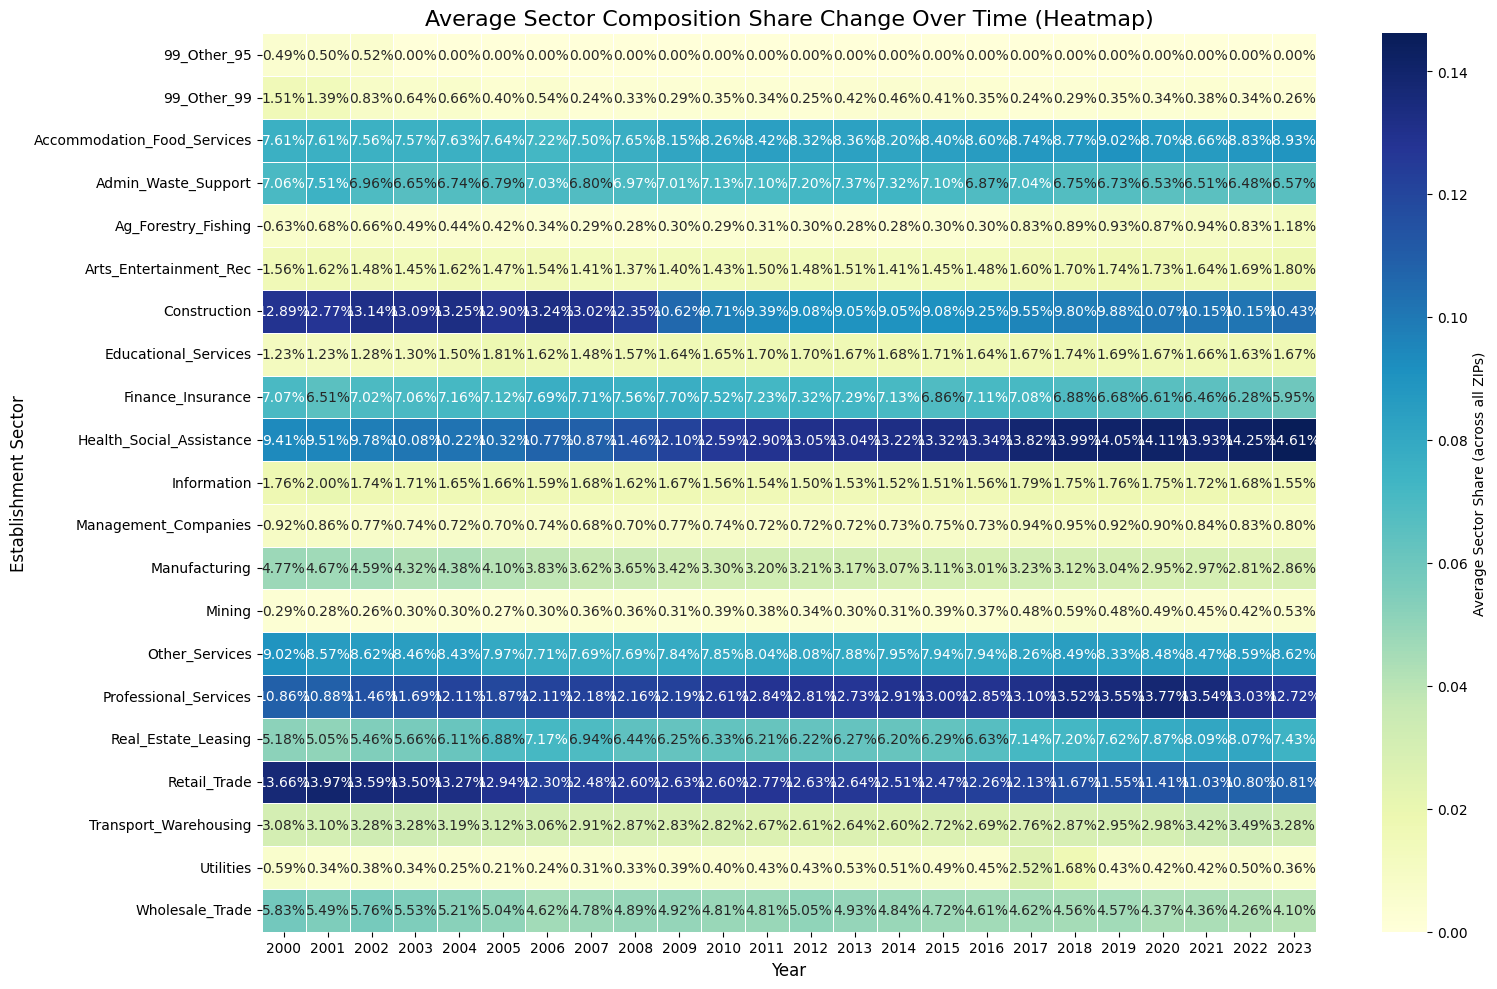

In [ ]:
# Sector Composition Heatmap (Relative Establishment Count)

# Calculate total count per ZIP per Year to get the baseline for relative share
zip_year_total = df.groupby(['ZIP', 'Year'])['EstablishmentCount'].sum().reset_index(name='Total_Count')

# Merge total count back into the main data
df_heatmap = pd.merge(df, zip_year_total, on=['ZIP', 'Year'])

# Calculate Sector Share within each ZIP-Year
df_heatmap['Sector_Share'] = df_heatmap['EstablishmentCount'] / df_heatmap['Total_Count']

# Group by Sector and Year (Averaging the share across all ZIPs)
sector_share_yearly = df_heatmap.groupby(['Establishment_Sector', 'Year'])['Sector_Share'].mean().unstack(fill_value=0)

plt.figure(figsize=(16, 10))
sns.heatmap(
    sector_share_yearly,
    cmap="YlGnBu",
    annot=True,
    fmt=".2%",
    linewidths=.5,
    cbar_kws={'label': 'Average Sector Share (across all ZIPs)'}
  )
plt.title('Average Sector Composition Share Change Over Time (Heatmap)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Establishment Sector', fontsize=12)
plt.tight_layout()
plt.show()

Modeling: Predicting Business Density (Linear Regression)

In [ ]:
# Split Data (using the cleaned df_model which contains the lagged variable)
train_data, test_data = train_test_split(df_model, test_size=0.2, random_state=42)

# Define the Model Formula
# C(ZIP) includes the ZIP code fixed effects
# Establishment_Sector is included as a categorical variable
# Year captures the linear time trend
# Lagged_Log_Density captures the auto-regressive (AR) component
model_formula = "Log_Business_Density ~ C(Establishment_Sector) + C(ZIP) + Year + Lagged_Log_Density"

# Fit the OLS model

model = smf.ols(formula=model_formula, data=train_data).fit()
print("\nOLS Model Summary (Linear Regression)")
print(model.summary())

# Make Predictions and Evaluate
predictions = model.predict(test_data)

ols_mse = mean_squared_error(test_data['Log_Business_Density'], predictions)
ols_r2 = r2_score(test_data['Log_Business_Density'], predictions)

print(f"\nModel Evaluation on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


OLS Model Summary (Linear Regression)
                             OLS Regression Results                             
Dep. Variable:     Log_Business_Density   R-squared:                       0.991
Model:                              OLS   Adj. R-squared:                  0.991
Method:                   Least Squares   F-statistic:                 2.836e+04
Date:                  Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                          01:14:24   Log-Likelihood:                 34257.
No. Observations:                 34324   AIC:                        -6.823e+04
Df Residuals:                     34184   BIC:                        -6.705e+04
Df Model:                           139                                         
Covariance Type:              nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

Visualization: Predictions vs. Actual Values

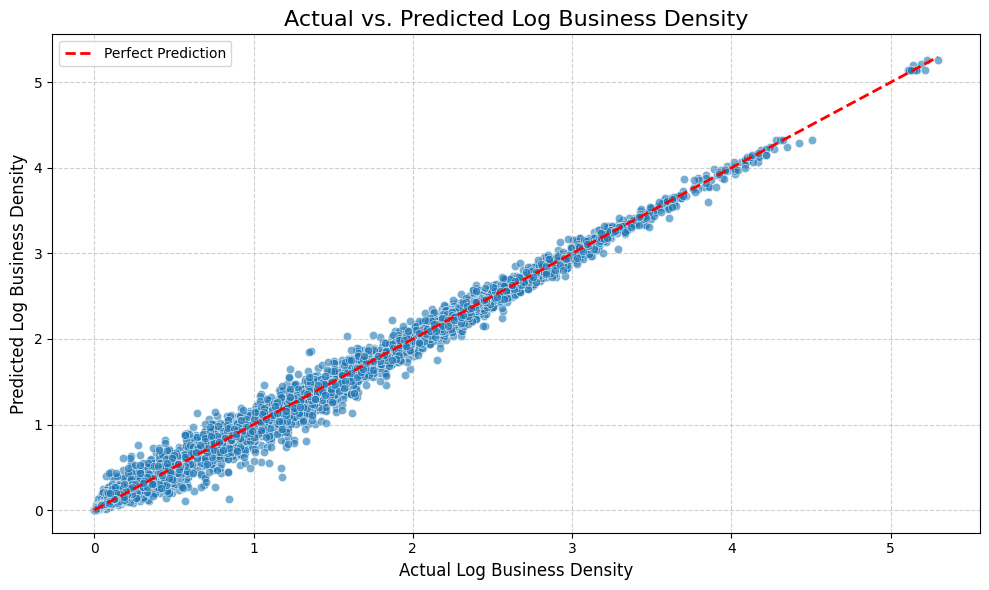

In [ ]:
# Create a prediction column in the test data
test_data['Predicted_Log_Density'] = predictions

plt.figure(figsize=(10, 6))

# Scatter plot of Actual vs. Predicted values
plt.scatter(test_data['Log_Business_Density'], test_data['Predicted_Log_Density'], alpha=0.6, edgecolors='w', linewidth=0.5)

# Plot the perfect prediction line (y=x)
max_val = test_data['Log_Business_Density'].max()
min_val = test_data['Log_Business_Density'].min()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted Log Business Density', fontsize=16)
plt.xlabel('Actual Log Business Density', fontsize=12)
plt.ylabel('Predicted Log Business Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## Modeling: Predicting Business Density (Random Forest Regression)



In [ ]:
# Prepare Data for ML Model

# Select features (X) and target (y)
X_data = df_model[['Establishment_Sector', 'ZIP', 'Year', 'Lagged_Log_Density']]
y_data = df_model['Log_Business_Density']

# One-hot encode categorical features (Sector and ZIP)
# ZIP codes are included as fixed effects using one-hot encoding
X_encoded = pd.get_dummies(X_data, columns=['Establishment_Sector', 'ZIP'], drop_first=True)

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_data, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# it the Random Forest Regressor
# Using a moderate number of estimators for speed and good performance
rf_model = RandomForestRegressor(n_estimators=100,
                                  random_state=42,
                                  n_jobs=-1, # Use all cores
                                  max_depth=10, # Limiting depth for regularization/speed
                                  min_samples_leaf=5) # Ensure robust split


rf_model.fit(X_train, y_train)

# Make Predictions and Evaluate
predictions = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, predictions)
rf_r2 = r2_score(y_test, predictions)

print(f"\nModel Evaluation on Test Set (Random Forest):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

#Feature Importance Analysis
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

print("\nTop 10 Feature Importances (Random Forest)")
print(feature_importances.head(10).to_markdown())


Training set size: 34324
Test set size: 8582

Model Evaluation on Test Set (Random Forest):
Mean Squared Error (MSE): 0.0078
R-squared (R2): 0.9917

Top 10 Feature Importances (Random Forest)
|                                               |           0 |
|:----------------------------------------------|------------:|
| Lagged_Log_Density                            | 0.998699    |
| Year                                          | 0.000413079 |
| Establishment_Sector_99_Other_99              | 0.000275315 |
| Establishment_Sector_Health_Social_Assistance | 4.08981e-05 |
| Establishment_Sector_Real_Estate_Leasing      | 3.27851e-05 |
| Establishment_Sector_Professional_Services    | 3.04368e-05 |
| Establishment_Sector_Retail_Trade             | 3.02844e-05 |
| Establishment_Sector_Construction             | 2.13412e-05 |
| Establishment_Sector_Transport_Warehousing    | 2.02394e-05 |
| ZIP_85295                                     | 2.02149e-05 |


### Visualization: Predictions vs. Actual Values (Random Forest)


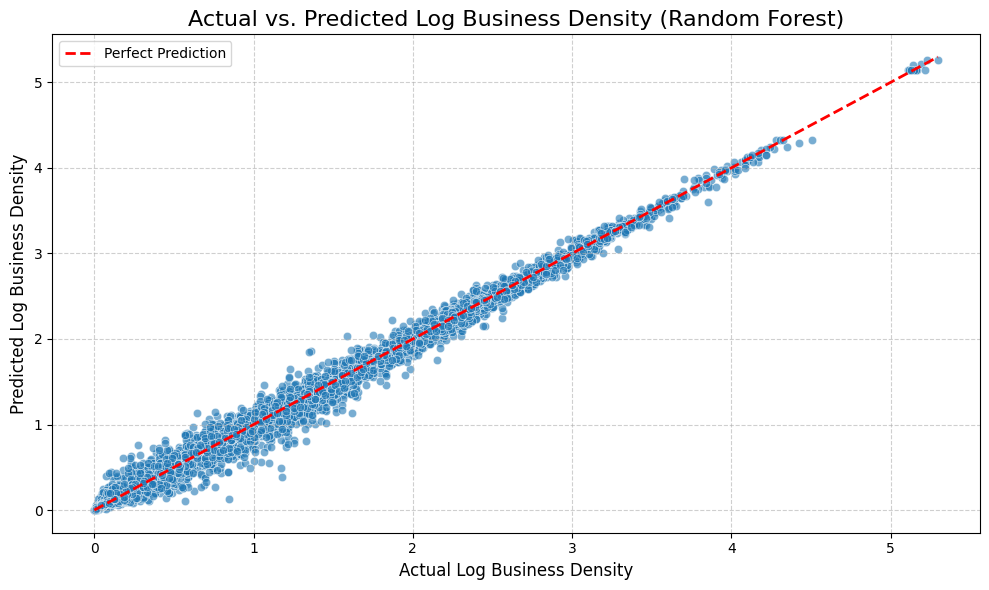

In [ ]:

plot_df = pd.DataFrame({
    'Actual_Log_Density': y_test,
    'Predicted_Log_Density': predictions
})

plt.figure(figsize=(10, 6))

# Scatter plot of Actual vs. Predicted values
plt.scatter(plot_df['Actual_Log_Density'], plot_df['Predicted_Log_Density'],
            alpha=0.6, edgecolors='w', linewidth=0.5)

# Plot the perfect prediction line (y=x)
max_val = plot_df['Actual_Log_Density'].max()
min_val = plot_df['Actual_Log_Density'].min()
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted Log Business Density (Random Forest)', fontsize=16)
plt.xlabel('Actual Log Business Density', fontsize=12)
plt.ylabel('Predicted Log Business Density', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import os

output_dir = './'

# Calculate and Export OLS Predictions and Residuals (on the full modeled data)

# Calculate predictions on the entire cleaned dataset (df_model) using the fitted OLS model
df_model_results = df_model.copy()
df_model_results['OLS_Predicted'] = model.predict(df_model_results)

# Calculate the residual: Actual Log Density - OLS Predicted Log Density
df_model_results['OLS_Residual'] = df_model_results['Log_Business_Density'] - df_model_results['OLS_Predicted']

# Select and rename the final columns for export
df_ols_results_export = df_model_results[[
    'Establishment_Sector',
    'ZIP',
    'Year',
    'Log_Business_Density',
    'Lagged_Log_Density',
    'OLS_Predicted',
    'OLS_Residual'
]].copy()

# Save the OLS results
ols_filepath = os.path.join(output_dir, 'ols_predictions_and_residuals.csv')
df_ols_results_export.to_csv(ols_filepath, index=False)
print(f"OLS results (including OLS_Residual) saved to: {ols_filepath}")

#Extract and Export Random Forest Feature Importances

# Extract the feature importances from the fitted RF model
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_encoded.columns
).sort_values(ascending=False)

# Convert the Series to a DataFrame for clean export
df_importances = feature_importances.reset_index()
df_importances.columns = ['Feature', 'Importance_Score']

# Save the RF feature importances
rf_importance_filepath = os.path.join(output_dir, 'rf_feature_importances.csv')
df_importances.to_csv(rf_importance_filepath, index=False)
print(f"RF Feature Importances saved to: {rf_importance_filepath}")

# Display the top 5 importances for quick check
print("\nTop 5 Feature Importances:")
print(df_importances.head(5).to_markdown(index=False))

OLS results (including OLS_Residual) saved to: ./ols_predictions_and_residuals.csv
RF Feature Importances saved to: ./rf_feature_importances.csv

Top 5 Feature Importances:
| Feature                                       |   Importance_Score |
|:----------------------------------------------|-------------------:|
| Lagged_Log_Density                            |        0.998699    |
| Year                                          |        0.000413079 |
| Establishment_Sector_99_Other_99              |        0.000275315 |
| Establishment_Sector_Health_Social_Assistance |        4.08981e-05 |
| Establishment_Sector_Real_Estate_Leasing      |        3.27851e-05 |


In [ ]:
df_metrics = pd.DataFrame({
    'Model': ['OLS', 'OLS', 'Random Forest', 'Random Forest'],
    'Metric': ['R-squared (R2)', 'Mean Squared Error (MSE)', 'R-squared (R2)', 'Mean Squared Error (MSE)'],
    'Value': [ols_r2, ols_mse, rf_r2, rf_mse]
})

# Export
metrics_filepath = os.path.join(output_dir, 'model_metrics_summary.csv')
df_metrics.to_csv(metrics_filepath, index=False)
print(f"Model Metrics Summary saved to: {metrics_filepath}")

Model Metrics Summary saved to: ./model_metrics_summary.csv
